In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from sklearn.metrics import f1_score

In [19]:

def show_binary_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    # Show the image
    plt.imshow(image, cmap=plt.cm.gray)
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])
    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.show()

image1 = cv2.imread("images/cells/9343 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image2 = cv2.imread("images/cells/10905 JL.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image3 = cv2.imread("images/cells/43590 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

ground_truth1 = cv2.imread("images/cells/9343 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth2 = cv2.imread("images/cells/10905 JL Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth3 = cv2.imread("images/cells/43590 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

def preprocess_ground_truth(image: np.ndarray):
    # Create a new array where True is set for elements that are 0 in the original image, and False otherwise
    mask = image == 0
    
    # Convert the boolean mask to integer (1 for True, 0 for False)
    preprocessed_image = mask.astype(int)
    
    return preprocessed_image


ground_truth1 = preprocess_ground_truth(ground_truth1)
ground_truth2 = preprocess_ground_truth(ground_truth2)
ground_truth3 = preprocess_ground_truth(ground_truth3)

# Open the GIF image
gif_image = Image.open('images/shakey.150.gif')

# Let's just take the first frame (index 0) for the static PNG
gif_image.seek(0) 

# Save the current frame as PNG
gif_image.save('images/shakey.png')

# Import PNG
shakey_image = cv2.imread("images/shakey.png", cv2.IMREAD_GRAYSCALE)



In [20]:
roberts_x = np.array([[1, 0],
                     [0, -1]])

roberts_y = np.array([[0, 1],
                      [-1, 0]])


sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = sobel_x.T #The roberts_y operator is the transpose of roberts_x and vice versa

def gaussian_kernel(size: int = 5, sigma: float = 1.0) -> np.ndarray: 
    """
    Generates a Gaussian kernel matrix for applying a Gaussian blur filter. 
    The kernel generated is a square matrix of dimensions size x size, 
    centered around the matrix origin, with values computed from the 2D Gaussian function.

    Parameters:
    - size (int, optional): The size of one side of the square Gaussian kernel. Must be a positive odd integer
      to ensure the kernel has a center. Defaults to 9, resulting in a 9x9 kernel.
    - sigma (float, optional): The standard deviation of the Gaussian distribution used in the
      kernel's calculation. This controls the spread of the blur; a larger sigma results in a blurrier image.
      Defaults to 2.0. 

    Returns:
    - np.ndarray: A 2D Numpy array of shape (size, size) containing the Gaussian kernel. The values
      are of type `np.float64`, ensuring high precision for the calculations. The kernel is normalized so that
      its sum equals 1, making it suitable for convolution operations without altering the image brightness.
   """ 

    size = int(size) // 2  # Ensuring the kernel size is effectively odd
    x, y = np.mgrid[-size:size+1, -size:size+1]  # Create a grid of (x, y) coordinates
    normal = 1 / (2.0 * np.pi * sigma**2)  # Normalization constant for the Gaussian function
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal  # Compute the Gaussian function
    return g / np.sum(g)  # Normalize and return the kernel

def zero_crossing(image, thresh=175): 
    
    z_c_image = np.zeros(image.shape)
    h,w = image.shape
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            patch = image[y-1:y+2, x-1:x+2]
            p = image[y, x]
            maxP = patch.max()
            minP = patch.min()
            if (p > 0):
                zeroCross = True if minP < 0 else False
            else:
                zeroCross = True if maxP > 0 else False
            if ((maxP - minP) > thresh) and zeroCross:
                z_c_image[y, x] = 1
    return z_c_image


def magnitude_img(G_x: np.ndarray, G_y: np.ndarray) -> np.ndarray:
    """
    Computes the magnitude of the gradient for an image given its horizontal (G_x)
    and vertical (G_y) gradients.

    Parameters:
    - G_x (np.ndarray): The gradient of the image in the x-direction (horizontal).
    - G_y (np.ndarray): The gradient of the image in the y-direction (vertical).

    Returns:
    - np.ndarray: The magnitude of the gradient at each point in the image. The returned
      array is of the same shape as the input arrays and contains the computed gradient
      magnitudes.
    """
    return np.sqrt(G_x**2 + G_y**2) 
  
def apply_sobel_filter(image: np.ndarray, gaussian_size: int = 5, sigma: float = 1.0, threshold: int = 50) -> np.ndarray:
  g = gaussian_kernel(gaussian_size, sigma)
  smoothed_image = scipy.signal.convolve2d(image, g, mode='same')
  G_x = scipy.signal.convolve2d(smoothed_image, sobel_x, mode='same')
  G_y = scipy.signal.convolve2d(smoothed_image, sobel_y, mode='same')
  edge_image = magnitude_img(G_x, G_y) >= threshold
  return edge_image  # Ensuring return type is consistent

def apply_roberts_filter(image: np.ndarray, gaussian_size: int = 5, sigma: float = 1.0, threshold: int = 50) -> np.ndarray:
  g = gaussian_kernel(gaussian_size, sigma)
  smoothed_image = scipy.signal.convolve2d(image, g, mode='same')
  G_x = scipy.signal.convolve2d(smoothed_image, roberts_x, mode='same')
  G_y = scipy.signal.convolve2d(smoothed_image, roberts_y, mode='same')
  edge_image = magnitude_img(G_x, G_y) >= threshold
  return edge_image  # Ensuring return type is consistent

def apply_first_order_gaussian(image: np.ndarray, gaussian_size: int = 5, sigma: float = 1.0, threshold: int = 50) -> np.ndarray:
    # Create a grid of coordinates for derivative computation
    x, y = np.meshgrid(np.arange(-gaussian_size//2 + 1, gaussian_size//2 + 1),
                       np.arange(-gaussian_size//2 + 1, gaussian_size//2 + 1))
    
    # Gaussian kernel for smoothing
    g = gaussian_kernel(gaussian_size, sigma)
    
    # First-order derivatives of Gaussian
    G_x = - (x / sigma**2) * g
    G_y = - (y / sigma**2) * g
    
    # Convolve image with G_x and G_y to get horizontal and vertical gradients
    grad_x = scipy.signal.convolve2d(image, G_x, mode='same', boundary='symm')
    grad_y = scipy.signal.convolve2d(image, G_y, mode='same', boundary='symm')
    
    # Compute gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Threshold gradient magnitude to detect edges
    edge_image = magnitude >= threshold
    
    return edge_image  # Ensuring return type is consistent

laplacian_kernel = np.array([[1,1,1],
                    [1, -8, 1],
                    [1,1,1]])

def apply_laplacian_filter(image: np.ndarray, threshold: int = 50) -> np.ndarray:
  image = scipy.signal.convolve2d(image, laplacian_kernel, mode='same')
  edge_image = zero_crossing(image, threshold)
  return edge_image

def apply_LoG_filter(image: np.ndarray, gaussian_size: int = 5, sigma: float = 1.0, threshold: int = 50) -> np.ndarray:
    # Calculate the range of x and y values
    radius = gaussian_size // 2
    x, y = np.mgrid[-radius:radius+1, -radius:radius+1]
    # Calculate the LoG
    norm = x**2 + y**2
    log = ((norm - 2.0 * sigma**2) / sigma**4) * np.exp(-norm / (2.0 * sigma**2))
    # Normalize the mask to have a sum of 0
    log -= log.mean()
    log_image = scipy.signal.convolve2d(image, log, mode='same')
    edge_image = zero_crossing(log_image, threshold)
    # return log_image, edge_image
    # return edge_image
    return log_image, edge_image


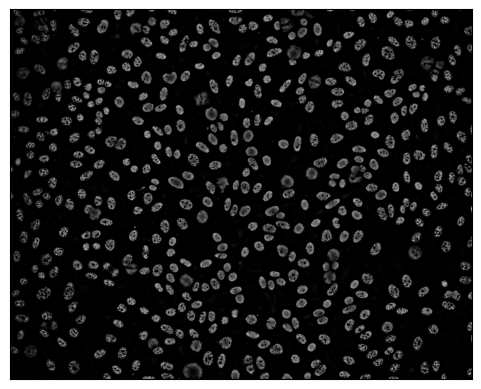

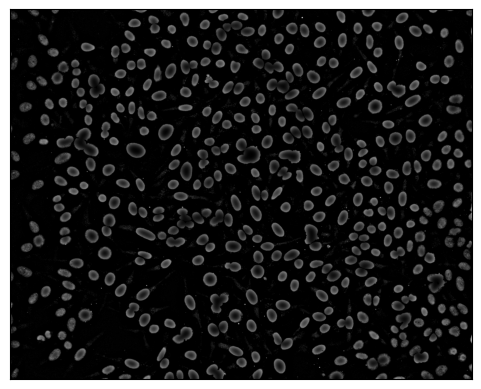

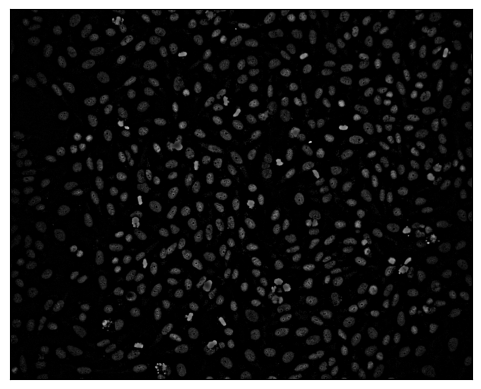

In [35]:
image1 = cv2.imread("images/cells/9343 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image2 = cv2.imread("images/cells/10905 JL.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image3 = cv2.imread("images/cells/43590 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

# Gaussian Blur for creating the unsharp mask
gaussian_blurred1 = cv2.GaussianBlur(image1, (3,3), 2)
# Subtract the blurred image from the original image to get the edges
edges1 = cv2.subtract(image1, gaussian_blurred1)
# Enhance the original image by adding the edges back to the original image
image1 = cv2.addWeighted(image1, 5, edges1, 3, 2)

# Gaussian Blur for creating the unsharp mask
gaussian_blurred2 = cv2.GaussianBlur(image2, (3,3), 2)
# Subtract the blurred image from the original image to get the edges
edges2 = cv2.subtract(image2, gaussian_blurred2)
image2 = cv2.addWeighted(image2, 5, edges2, 3, 2)

# Gaussian Blur for creating the unsharp mask
gaussian_blurred3 = cv2.GaussianBlur(image3, (3,3), 2)
# Subtract the blurred image from the original image to get the edges
edges3 = cv2.subtract(image3, gaussian_blurred3)
# Enhance the original image by adding the edges back to the original image
image3 = cv2.addWeighted(image3, 5, edges3, 3, 2)


# Function to apply high-pass filter directly to an image array
def apply_high_pass_filter(image):
    # Apply Gaussian blur to create a low-pass filter effect
    # blurred_image = cv2.GaussianBlur(image, (49, 49), 8)
    blurred_image = cv2.GaussianBlur(image, (49, 49), 8)
    
    # Subtract the blurred (low-pass filtered) image from the original to get high-pass filtered image
    high_pass_filtered_image = cv2.subtract(image, blurred_image)
    
    return high_pass_filtered_image


# Apply the high-pass filter to each image
image1 = apply_high_pass_filter(image1)
image2 = apply_high_pass_filter(image2)
image3 = apply_high_pass_filter(image3)

show_binary_image(image1)
show_binary_image(image2)
show_binary_image(image3)


In [36]:

def calculate_f1_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """
    Calculate the F1 score between the ground truth and the prediction.

    Parameters:
    - ground_truth (np.ndarray): The ground truth binary image (edges marked with 1).
    - prediction (np.ndarray): The predicted edge binary image.

    Returns:
    - float: The F1 score as a float between 0 and 1, where 1 represents perfect agreement.
    """
    # Flatten arrays to 1D for compatibility with f1_score function
    ground_truth_flat = ground_truth.flatten()
    prediction_flat = prediction.flatten()
    
    # Calculate and return F1 score
    return f1_score(ground_truth_flat, prediction_flat)

# Define the grid search function
def grid_search_threshold(edge_detection_fn, thresholds, images, ground_truths):
    optimal_threshold = None
    highest_avg_f1 = -1
    
    for threshold in thresholds:
        f1_scores = []
        for image, ground_truth in zip(images, ground_truths):
            # predicted_edges = edge_detection_fn(image, threshold=threshold)
            
            result = edge_detection_fn(image, threshold=threshold)
            predicted_edges = result if not isinstance(result, tuple) else result[1]

                
            f1_score = calculate_f1_score(ground_truth, predicted_edges)
            f1_scores.append(f1_score)
        
        avg_f1 = np.mean(f1_scores)
        if avg_f1 > highest_avg_f1:
            highest_avg_f1 = avg_f1
            optimal_threshold = threshold
            print(f"New optimal {optimal_threshold} with f1 score: {highest_avg_f1}")
        else:
            break
    
    return optimal_threshold, highest_avg_f1



thresholds = range(130, 255, 1)  # Example: 0, 1, 2, ..., 254

images = [image1, image2, image3]
ground_truths = [ground_truth1, ground_truth2, ground_truth3]

# Define edge detection functions that can accept gaussian_size and sigma parameters
edge_detection_functions = [
    ("Laplacian", apply_laplacian_filter),  
]



    
for name, fn in edge_detection_functions:
    optimal_threshold, highest_avg_f1 = grid_search_threshold(fn, thresholds, images, ground_truths)
    print(f"{name} - Final Optimal Parameters: Threshold: {optimal_threshold}, Highest Avg F1 Score: {highest_avg_f1}")



New optimal 130 with f1 score: 0.4557766322443822
New optimal 131 with f1 score: 0.45585515322607567
New optimal 132 with f1 score: 0.4560206573301718
Laplacian - Final Optimal Parameters: Threshold: 132, Highest Avg F1 Score: 0.4560206573301718


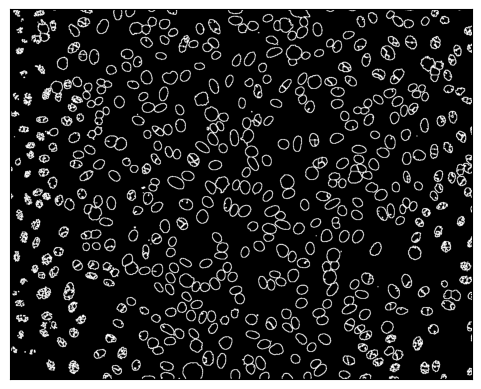

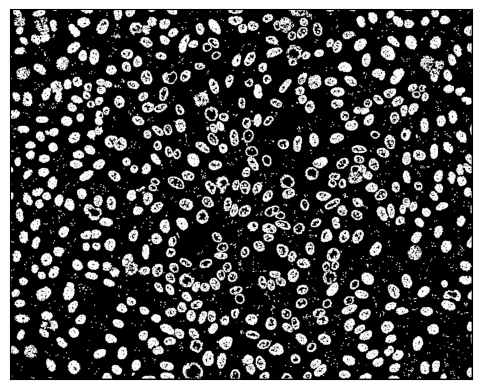

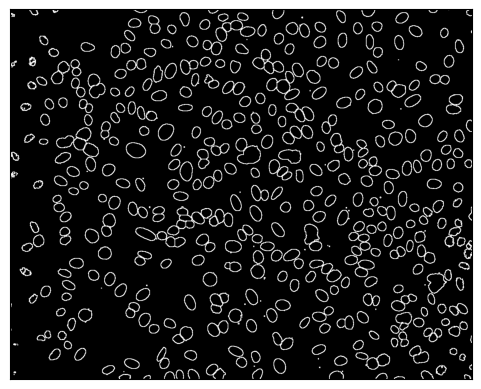

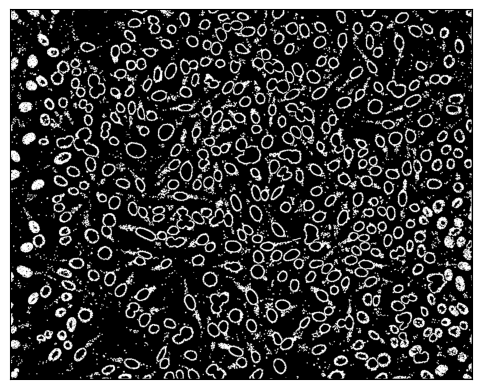

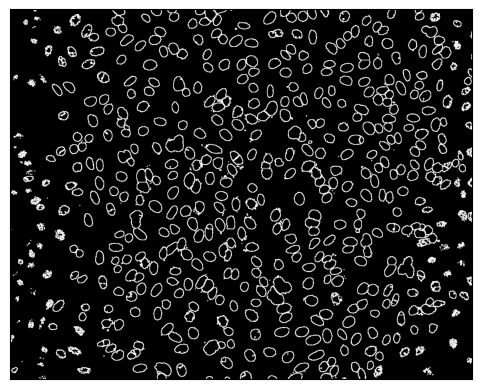

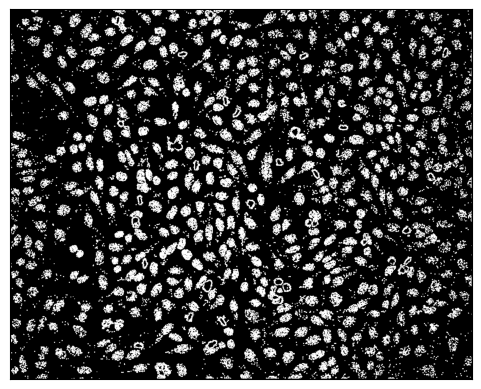

In [28]:


laplacian_edge_image1 = apply_laplacian_filter(image1, threshold=132)
laplacian_edge_image2 = apply_laplacian_filter(image2, threshold=132)
laplacian_edge_image3 = apply_laplacian_filter(image3, threshold=132)

show_binary_image(ground_truth1)
show_binary_image(laplacian_edge_image1)
show_binary_image(ground_truth2)
show_binary_image(laplacian_edge_image2)
show_binary_image(ground_truth3)
show_binary_image(laplacian_edge_image3)